In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib as mpl
PATH = '/Users/zachary/Desktop/'
zhfont = mpl.font_manager.FontProperties(fname=PATH + 'simhei.ttf')

## 预处理编号为285号和313号的历史数据

In [2]:
PATH = 'data/'
FileName = '附件三：285号和313号样本原始数据.xlsx'

In [3]:
DF_285 = pd.read_excel(PATH + FileName, sheet_name='285')
DF_313 = pd.read_excel(PATH + FileName, sheet_name='313')

time_285 = DF_285['时间'].values[1:]
var_data_285 = DF_285.values[1:, 1:].astype(np.float)
time_313 = DF_285['时间'].values[1:]
var_data_313 = DF_313.values[1:, 1:].astype(np.float)

285号数据缺失统计

In [4]:
stats_285, stats_313 = [], []
nan_285_idx, nan_313_idx = [], []
for j in range(var_data_285.shape[1]):
    count_285 = np.sum(var_data_285[:,j] == 0)
    stats_285.append(count_285/var_data_285.shape[0])
    if count_285 > 0:
        nan_285_idx.append(j)
    
    count_313 = np.sum(var_data_313[:,j] == 0)
    stats_313.append(count_313/var_data_285.shape[0])
    if count_313 >= 16:
        nan_313_idx.append(j)

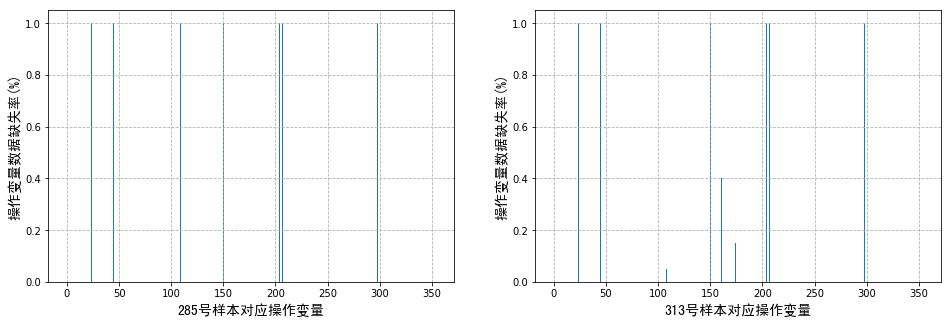

In [5]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.bar(range(var_data_285.shape[1]) ,stats_285)
plt.xlabel('285号样本对应操作变量', fontproperties=zhfont, fontsize=14)
plt.ylabel('操作变量数据缺失率(%)', fontproperties=zhfont, fontsize=14)
plt.grid(linestyle='--')


plt.subplot(1,2,2)
plt.bar(range(var_data_313.shape[1]) ,stats_313)
plt.xlabel('313号样本对应操作变量', fontproperties=zhfont, fontsize=14)
plt.ylabel('操作变量数据缺失率(%)', fontproperties=zhfont, fontsize=14)
plt.grid(linestyle='--')

plt.show()

In [6]:
print('number 285, nan ratio != 0:', np.where(np.array(stats_285) != 0)[0])
print('number 313, nan ratio != 0:', np.where(np.array(stats_313) != 0)[0])

number 285, nan ratio != 0: [ 24  45  73  95 109 150 204 207 215 298 331]
number 313, nan ratio != 0: [ 24  45  95 108 150 161 174 204 207 215 283 298 329]


In [7]:
ratio_num_285, ratio_num_313 = [], []
for ratio in [0, 0.05, 0.1, 0.41]:
    ratio_num_285.append(np.sum(np.array(stats_285, dtype=np.float) >= ratio))
    ratio_num_313.append(np.sum(np.array(stats_313, dtype=np.float) >= ratio))

pie_285, pie_313 = [], []
pie_285.append(ratio_num_285[-1])
pie_313.append(ratio_num_313[-1])
for i in range(1, len(ratio_num_285)):
    idx = len(ratio_num_285) - i
    pie_285.append(ratio_num_285[idx-1] - ratio_num_285[idx])
    pie_313.append(ratio_num_313[idx-1] - ratio_num_313[idx])
pie = np.array(pie_285) + np.array(pie_313)


In [8]:
pie[1] = 4

In [1]:
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签

plt.figure(figsize=(20, 6.5))
plt.pie(pie, explode=(0,0.1,0.3,0.5),autopct='%.2f%%',labels=['40%-100%', '10%-40%', '5%-10%', 'None'], labeldistance=1)
plt.xlabel('样本对应操作变量的缺失率统计', fontproperties=zhfont, fontsize=14)
plt.legend(fontsize=14)

NameError: name 'plt' is not defined

## 针对不同缺失程度的数据，进行不同操作

（1）对于编号为285和313的数据，分别使用规范值来约束，使用最大最小的方式来替换；
（2）缺失数据：对于285号样本的缺失数据，因为全部为，所以不做任何处理；对于313编号的数据，若缺失率小于40%，分别进行基于滑动窗口进行均值填充
（3）使用拉依达准则对有问题的数据进行处理；

In [10]:
DF_standard = pd.read_excel(PATH + '附件四：354个操作变量信息.xlsx')

name_standard = DF_standard['位号'].values
scale_standard = DF_standard['取值范围'].values

In [11]:
def preprocess(var_data_285):
    update_idx = []
    sum1, sum2, sum3 = 0, 0, 0
    for j in range(var_data_285.shape[1]):
        # name 是编号285中操作变量的名称
        name_285 = DF_285.columns[j+1]
        if name_285 in name_standard:
            idx_standard = np.where(name_standard == name_285)[0]
            tmp_scale = scale_standard[idx_standard]
            # 找到每个操作变量的上下范围（low-high）
            if '-' == tmp_scale[0][0]:
                tmp_scale = tmp_scale[0][1:]
                idx1 = tmp_scale.index('-')
                low = -float(tmp_scale[:idx1])
                if '(' in tmp_scale:
                    idx2 = tmp_scale.index('(')
                    idx3 = tmp_scale.index(')')
                    high = float(tmp_scale[idx2+1:idx3])
                elif '（' in tmp_scale:
                    idx2 = tmp_scale.index('（')
                    idx3 = tmp_scale.index('）')
                    high = float(tmp_scale[idx2+1:idx3])
                else:
                    high = float(tmp_scale[idx1+1:])
            else:
                low, high = tmp_scale[0].split('-')
                low, high = float(low), float(high)

            # (1) 统计不合上下值范围的数据，并进行修正
            count_low_idx = np.where(var_data_285[:,j]<low)[0]
            count_high_idx = np.where(var_data_285[:,j]>high)[0]
            
            if len(count_low_idx) != 0:
                var_data_285[count_low_idx,j] = low
                sum1 += 1
            if len(count_high_idx) != 0:
                var_data_285[count_high_idx,j] = high
                sum1 += 1

            # (2) 找到缺失值小于40%的数据列并进行滑动窗口缺失值补充
            count_nan_idx = np.where(var_data_285[:,j] == 0)[0]
            if 0< len(count_nan_idx) <= 16:
                update_idx.append(j)
                for i in count_nan_idx:
#                     print(var_data_285[i,j], '-->')
                    var_data_285[i,j] = np.mean(var_data_285[i-4:i+4,j])
                    sum2 += 1
#                     print(var_data_285[i,j])
            
            # (3) 基于拉依达准则进行异常值的剔除
            mean = np.mean(var_data_285[:,j])
            std = np.std(var_data_285[:,j])
            lower = mean - 3*std
            higher = mean + 3*std
            
            count_lower_idx = np.where(var_data_285[:,j]<lower)[0]
            count_higher_idx = np.where(var_data_285[:,j]>higher)[0]
            if len(count_lower_idx) != 0:
                var_data_285[count_lower_idx,j] = low
                sum3 += 1
            if len(count_higher_idx) != 0:
                var_data_285[count_higher_idx,j] = high
                sum3 += 1
    
    return var_data_285, update_idx, sum1, sum2, sum3

prep_data_285, update_idx_285, sum1, sum2, sum3 = preprocess(var_data_285)
prep_data_285 = np.mean(prep_data_285, axis=0)
print('num_285:', sum1, sum2, sum3)

prep_data_313, update_idx_313, sum1, sum2, sum3 = preprocess(var_data_313)
prep_data_313= np.mean(prep_data_313, axis=0)
print('num_313:',sum1, sum2, sum3)

num_285: 3 0 0
num_313: 32 42 53


/Users/zachary/Desktop/AnacPython/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/zachary/Desktop/AnacPython/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/zachary/Desktop/AnacPython/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in less
/Users/zachary/Desktop/AnacPython/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in greater


In [12]:
print('313好样本，通过缺失值(<=40%)补充的样本数据名称有：', list(DF_313.columns[np.array(update_idx_313) + 1]))

313好样本，通过缺失值(<=40%)补充的样本数据名称有： ['S-ZORB.PC_6001.PV', 'S-ZORB.FC_2432.DACA', 'S-ZORB.PDI_2801.DACA', 'S-ZORB.PDI_2301.DACA', 'S-ZORB.FC_2432.PIDA.SP', 'S-ZORB.FT_1204.DACA.PV']


In [13]:
lost_data_idx = list((set(np.where(np.array(stats_285))[0]) | set(np.where(np.array(stats_313))[0])) - set(update_idx_313))

print('统计285和313最终抛弃掉的样本点数据名称为：', list(DF_313.columns[np.array(lost_data_idx) + 1]))

统计285和313最终抛弃掉的样本点数据名称为： ['S-ZORB.FC_1202.PV', 'S-ZORB.TEX_3103A.DACA', 'S-ZORB.FT_5102.DACA.PV', 'S-ZORB.FC_1104.DACA', 'S-ZORB.FT_1204.PV', 'S-ZORB.FT_5102.PV', 'S-ZORB.FT_2803.DACA', 'S-ZORB.FT_1002.PV', 'S-ZORB.FT_2431.DACA', 'S-ZORB.FT_2901.DACA', 'S-ZORB.FT_1502.DACA', 'S-ZORB.FT_1501.PV', 'S-ZORB.FT_1501.TOTAL']


In [14]:
DF = pd.read_excel(PATH + '附件一：325个样本数据.xlsx')
DF.head()

,样本编号,时间,"硫含量,μg/g",辛烷值RON,"饱和烃,v%（烷烃+环烷烃）","烯烃,v%","芳烃,v%","溴值 ,gBr/100g","密度(20℃), kg/m³","硫含量,μg/g.1",...,S-ZORB.CAL_1.CANGLIANG.PV,S-ZORB.FT_1006.DACA.PV,S-ZORB.FT_5204.DACA.PV,S-ZORB.FT_1006.TOTALIZERA.PV,S-ZORB.FT_5204.TOTALIZERA.PV,S-ZORB.FT_1503.DACA.PV,S-ZORB.FT_1503.TOTALIZERA.PV,S-ZORB.FT_1504.DACA.PV,S-ZORB.FT_1504.TOTALIZERA.PV,S-ZORB.PC_1001A.PV
0,1,2020/5/26 8:00:00,188.0,90.6,53.230000,24.400000,22.370000,61.487143,726.085714,3.2,...,2.045436,6368.74700,233.310805,83086802.0,832503.795,2216.40935,39063124.5,1840.14470,39608757.0,0.353271
1,2,2020/5/21 8:00:00,169.0,90.5,52.300000,26.400000,21.300000,61.880000,731.300000,3.2,...,2.025974,6360.64530,242.369205,82318954.0,803462.665,2370.58740,38810581.5,1641.73260,39389299.0,0.354504
2,3,2020/5/19 8:00:00,177.0,90.7,52.300000,26.314286,21.385714,61.722857,729.614286,3.2,...,1.964696,6504.96490,233.076925,82012004.0,791925.055,2326.46535,38693812.0,1600.67575,39312616.5,0.350181
3,4,2020/5/14 8:00:00,159.0,90.4,52.300000,26.100000,21.600000,61.330000,725.400000,3.2,...,2.039041,6506.82495,238.349935,81231373.5,762863.810,2495.22360,38410862.5,1563.71215,39120204.5,0.353930
4,5,2020/5/12 8:00:00,173.0,89.6,52.242857,26.671429,21.085714,61.332857,725.428571,3.2,...,1.986900,6560.24225,236.576220,80915707.5,751362.300,2807.78910,38283000.0,1554.35740,39045953.5,0.358053


In [15]:
data = DF.values

In [16]:
add_285 = np.array([199,89.3,60.06,14.93,25.02,53,726.5,    3.2,88.1,0, 3.61,4.8,1.25,3.37], dtype=np.float).reshape((1,-1))
add_313 = np.array([392,55.05,90.3,20.89,24.06,59.09,725.2, 8.5,88.9,0, 3.77,9.24,3.45,7.29], dtype=np.float).reshape((1,-1))

In [17]:
ADD_285 = np.hstack((add_285, prep_data_285.reshape((1,-1))))
ADD_313 = np.hstack((add_313, prep_data_313.reshape((1,-1))))

data[284,2:] = ADD_285
data[312,2:] = ADD_313

In [18]:
print('通过285和313抛弃的数据有：', np.sort(lost_data_idx))
data_nan_idx = []
for j in range(len(ADD_285)+1, data.shape[1]):
    nan_idx = np.where(data[:,j] == 0)[0]
    nan_ratio = len(nan_idx) / data.shape[0]
    if nan_ratio > 0.1:
        data_nan_idx.append(j-16)
        data[:,j] = 0
    else:
        for idx in nan_idx:
            data[idx, j] = np.mean(data[idx-5:idx+5, j])
print('通过所有抛弃的数据有：', np.sort(data_nan_idx))
print('二者共同的存在的有：', np.sort(list(set(data_nan_idx) & set(lost_data_idx))))


whole_nan_idx = np.sort(list(set(lost_data_idx) | set(data_nan_idx)))

print('\n', whole_nan_idx)

通过285和313抛弃的数据有： [ 24  45  73  95 108 109 150 174 204 207 215 298 331]
通过所有抛弃的数据有： [ 12  24  25  27  45  73  77  88  95 109 150 204 207 215 222 298 331 345
 346]
二者共同的存在的有： [ 24  45  73  95 109 150 204 207 215 298 331]

 [ 12  24  25  27  45  73  77  88  95 108 109 150 174 204 207 215 222 298
 331 345 346]


In [19]:
original_ROM = np.array(data[:,3], dtype=np.float64)
processed_ROM = np.array(data[:,10], dtype=np.float64)

def cal_coff(data, original_ROM):
    related_idx0, unrelated_idx0 = [], []
    for j in range(16,data.shape[1]):
        tmp = np.array(data[:,j], dtype=np.float64)
        coff = np.corrcoef(tmp, original_ROM)
        if (j-16) in whole_nan_idx:
            if np.isnan(coff[0,1]):
                unrelated_idx0.append(0)
            else:
                unrelated_idx0.append(float(coff[0,1]))
        else:
            if np.isnan(coff[0,1]):
                related_idx0.append(0)
            else:
                related_idx0.append(abs(float(coff[0,1])))
    return related_idx0, unrelated_idx0

related_idx0, unrelated_idx0 = cal_coff(data, original_ROM)
related_idx1, unrelated_idx1= cal_coff(data, processed_ROM)


/Users/zachary/Desktop/AnacPython/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/zachary/Desktop/AnacPython/lib/python3.7/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [20]:
print('原料RON与所有数据的平均皮尔逊相关洗系数：{0:.4f}'.format(np.mean(related_idx0)))
print('原料RON与各丢弃样本数据的皮尔逊相关洗系数：', unrelated_idx0)

print('原料RON与所有数据的平均皮尔逊相关洗系数：{0:.4f}'.format(np.mean(related_idx1)))
print('原料RON与各丢弃样本数据的皮尔逊相关洗系数：', unrelated_idx1)

原料RON与所有数据的平均皮尔逊相关洗系数：0.0559
原料RON与各丢弃样本数据的皮尔逊相关洗系数： [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.012718566586495905, 0, 0, -0.032182749224248006, 0, 0, 0, 0, 0, 0, 0, 0]
原料RON与所有数据的平均皮尔逊相关洗系数：0.1538
原料RON与各丢弃样本数据的皮尔逊相关洗系数： [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.04561784850378039, 0, 0, -0.15231758810262055, 0, 0, 0, 0, 0, 0, 0, 0]


In [21]:
data[:, np.array(whole_nan_idx)+16] = 0

In [22]:
col_name = list(DF.columns)
DF = pd.DataFrame(data)
DF.columns = col_name

DF.to_excel(PATH + 'processed_data.xlsx')

In [23]:
prep_data_313, update_idx_313, sum1, sum2, sum3 = preprocess(data[:,16:])